In [2]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [3]:
filename_queue = tf.train.string_input_producer(tf.train.match_filenames_once("pikachu_pic/*.jpg"))
#filename_queue = tf.train.string_input_producer(["pikachu_pic/1567.jpg"])
image_reader = tf.WholeFileReader()

_, image_file = image_reader.read(filename_queue)

decode_image = tf.image.decode_jpeg(image_file, channels = 1)

In [4]:
decode_image

<tf.Tensor 'DecodeJpeg:0' shape=(?, ?, 1) dtype=uint8>

In [5]:
image = tf.cast(decode_image, tf.float32)

In [6]:
resize_img = tf.image.resize_images(image, [28, 28])

In [7]:
resize_img

<tf.Tensor 'Squeeze:0' shape=(28, 28, 1) dtype=float32>

In [8]:
image_batch = tf.train.batch([resize_img], batch_size=10)

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners( coord = coord)
    
    try:
        img = image_batch.eval()
    finally:
        coord.request_stop()
        coord.join(threads)

In [10]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4
        
        # d4 contains unscaled values
        return d4

In [11]:
def generator(z, batch_size, z_dim):
    # From z_dim to 56*56 dimension
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [13]:
%matplotlib inline
""" See the fake image we make """

# Define the plceholder and the graph
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

# For generator, one image for a batch
generated_image_output = generator(z_placeholder, 1, z_dimensions)

In [14]:
z_batch = np.random.normal(0, 1, [1, z_dimensions])



(1, 100)

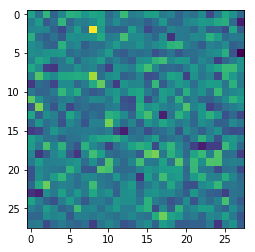

In [12]:
%matplotlib inline
""" See the fake image we make """

# Define the plceholder and the graph
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

# For generator, one image for a batch
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image)

In [13]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

# Two Loss Functions for discriminator
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

# Loss function for generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))


# Get the varaibles for different network
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


In [14]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [15]:
# """ For setting TensorBoard """

# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

# tf.summary.scalar('Generator_loss', g_loss)
# tf.summary.scalar('Discriminator_loss_real', d_loss_real)
# tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

# images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
# tf.summary.image('Generated_images', images_for_tensorboard, 5)
# merged = tf.summary.merge_all()
# logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
# writer = tf.summary.FileWriter(logdir, sess.graph)


""" Start Training Session """

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    #real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])

    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: img, z_placeholder: z_batch})

    if(i % 100 == 0):
#         # show weight
#         d_w1 = tf.get_variable('d_w1')
#         tmp = sess.run(d_w1)
#         print(tmp)
        
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

dLossReal: 1.13196 dLossFake: 0.712075
dLossReal: 0.0753841 dLossFake: 0.66893
dLossReal: 4.85766e-05 dLossFake: 0.4553


Model saved in file: /tmp/model0.ckpt
Iteration: 0 at 2017-09-18 17:52:00.006407
Estimate: [[-4.58332682]]
Iteration: 100 at 2017-09-18 17:53:02.757325
Estimate: [[-7.4326911]]
Iteration: 200 at 2017-09-18 17:54:03.210793
Estimate: [[-10.81710339]]
Iteration: 300 at 2017-09-18 17:55:03.700217
Estimate: [[-11.84803677]]
Iteration: 400 at 2017-09-18 17:56:03.657786
Estimate: [[-12.72589684]]
Iteration: 500 at 2017-09-18 17:57:03.803729
Estimate: [[-12.65691662]]
Iteration: 600 at 2017-09-18 17:58:03.984375
Estimate: [[-12.2799921]]
Iteration: 700 at 2017-09-18 17:59:04.013993
Estimate: [[-12.74186039]]
Iteration: 800 at 2017-09-18 18:00:03.990836
Estimate: [[-17.27479362]]
Iteration: 900 at 2017-09-18 18:01:03.862677
Estimate: [[-6.50481033]]
Model saved in file: /tmp/model1000.ckpt
Iteration: 1000 at 2017-09-18 18:02:06.307695
Estimate: [[-9.41299915]]
Iteration: 1100 at 2017-09-18 18:03:06.639505
Estimate: [[-10.21682262]]
Iteration: 1200 at 2017-09-18 18:04:07.029486
Estimate: [[-12.3

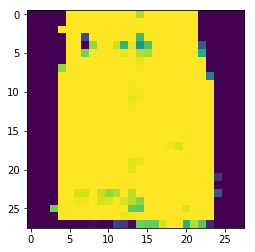

In [16]:
# Train generator and discriminator together
for i in range(100000):
    real_image_batch = img
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    # if i % 10 == 0:
    #     # Update TensorBoard with summary statistics
    #     z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    #     summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
    #     writer.add_summary(summary, i)
    
    if i % 1000 == 0:
        # Save the model every 1000 iteration
        save_path = saver.save(sess, "/tmp/model{}.ckpt".format(i))
        print("Model saved in file: %s" % save_path)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]))
        plt.savefig("Pikachu_img/image{}.png".format(i))

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)



NameError: name 'np' is not defined